In [5]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [6]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 200

5.156942649668705


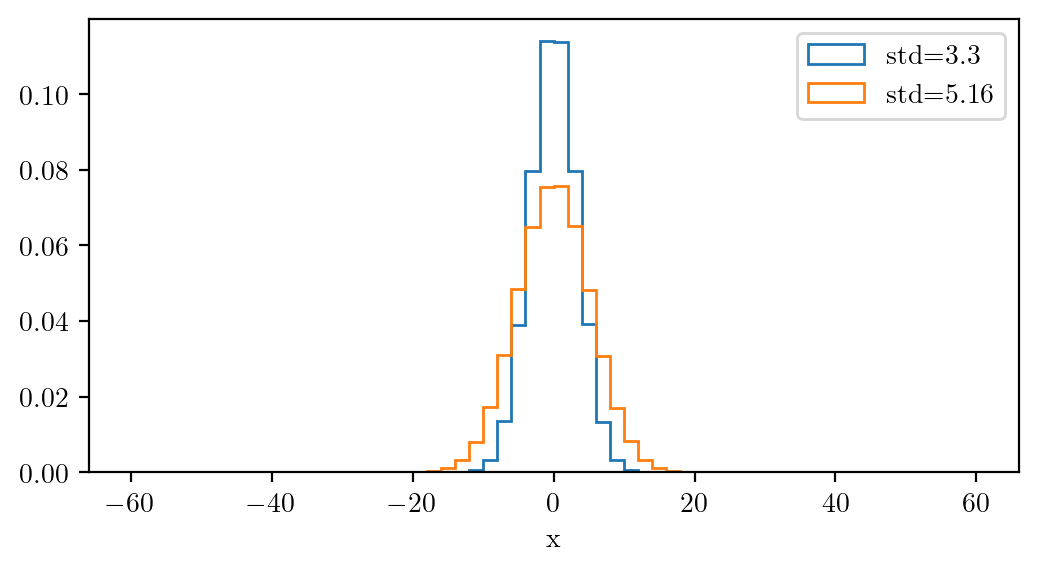

In [89]:

plt.figure(figsize=(6,3))

# Rough representation of the residuals
N_points = 1000000

x = np.random.normal(loc=0, scale=3.3, size=N_points)
plt.hist(x, bins=60, range=(-60, 60), density=True, label="std=3.3", histtype="step");

x = np.random.normal(loc=0, scale=5.16, size=N_points)
plt.hist(x, bins=60, range=(-60, 60), density=True, label="std=5.16", histtype="step");

# x = np.random.normal(loc=0, scale=15.13, size=N_points)
# plt.hist(x, bins=100, range=(-60, 60), density=True, label="std=15.13", histtype="step");

plt.xlabel('x')
plt.legend()

# RMS
rms = np.std(x)
print(rms)



$$
\text{average of residuals} = \left[\frac{\left(\lambda_{n, p, \text { pred. }}-\lambda_{p, \text { theory }}\right)}{\lambda_{p, \text { theory }}} \times c\right]
$$


$$
\text{residuals} = \left[\frac{\left(\lambda_{n, p, \text { pred. }}-\lambda_{p, \text { theory }}\right)}{\lambda_{p, \text { theory }}} \times c\right]
$$

"RMS/line" = 10.0
"std_line" = 10.0
Average = 0.00592


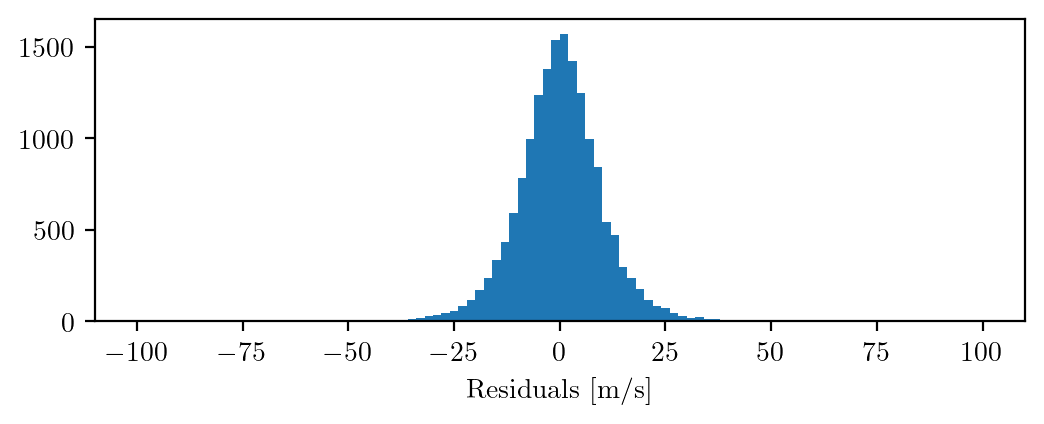

In [69]:
# Plot residuals
residuals = np.genfromtxt("fit_results/residuals_interp_all_peaks_every_2nd_flipped_with_errors_sqrt3_ms_chi2sorted.csv")
# residuals = np.genfromtxt("fit_results/residuals_pchip_sqrt1.csv")
fig, ax = plt.subplots(figsize=(6,2))
ax.hist(residuals, range=(-100, 100), bins=100)
ax.set_xlabel("Residuals [m/s]")

# compute RMS/line
summation_term = residuals**2/len(residuals)
rms_line = np.sqrt(np.sum(summation_term))
std_line = round(np.nanstd(residuals),2)

print(f'"RMS/line" = {rms_line:.3}')
print(f'"std_line" = {std_line:.3}')

av = np.mean(residuals)
print(f"Average = {av:.3}")


(0.0, 3000.0)

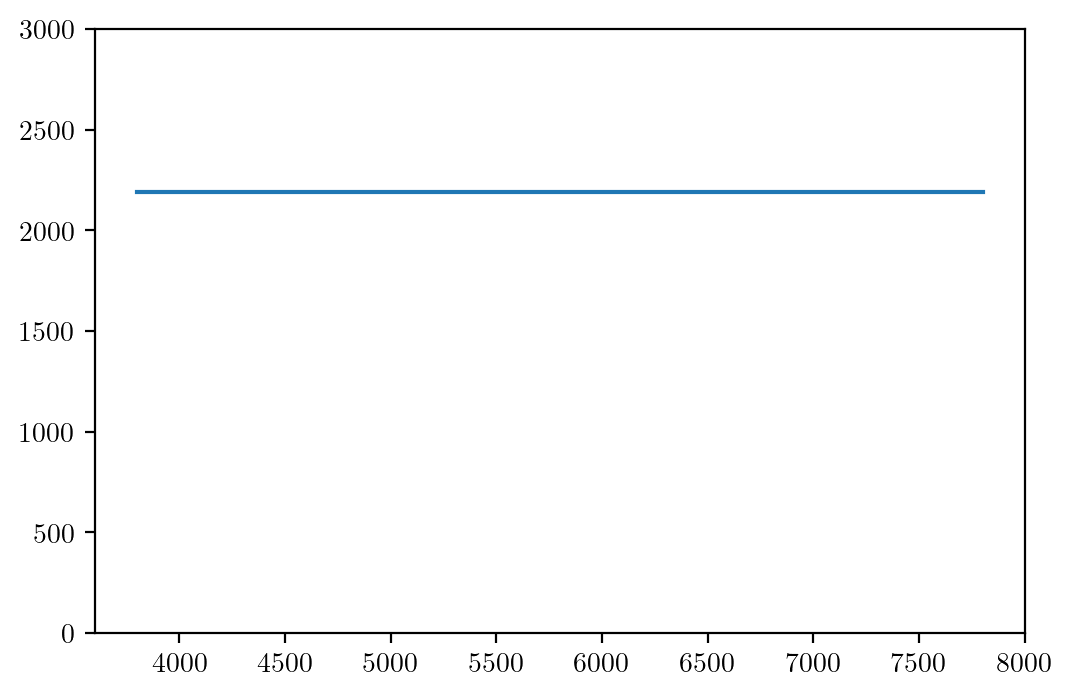

In [40]:
c = 299792458 # m/s

L = np.linspace(3800, 7800, 100)
DL = L/137000
L2 = L + DL

v = (L2 - L)/L * c

plt.plot(L, v)
plt.ylim(0, 3000)

# plt.hist(v, bins=10);

### Inpsect excalibur shift

In [48]:
filenames = get_all_spectra_filenames()

# Take the excalibur wavelength for each pixel across all observations

matrices = []

# make 2d matrix with wavel for all obs
for file in filenames:
    data = load_spectra_fits(file)
    mat = np.array([data['bary_excalibur'][o] for o in np.arange(len(data['bary_excalibur']))]) 
    matrices.append(mat)



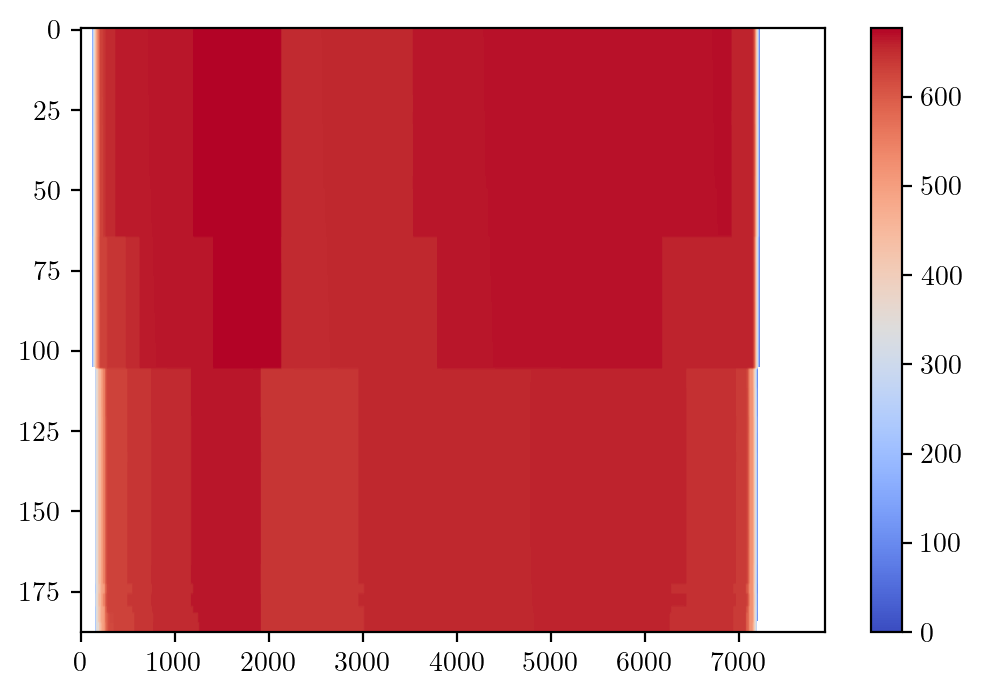

In [59]:
# mean_mat = np.nanmean(matrices, axis=1)
std_mat = np.nanstd(matrices, axis=1)
k = plt.imshow(std_mat, aspect="auto", cmap=plt.get_cmap("coolwarm"))
# cax = make_axes_locatable(ax3).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
plt.colorbar(k)

In [64]:
len(matrices)

188